# EHR-ML with complete data

## Read data

In [1]:
import os
import pandas as pd


datamatrixDf = pd.read_csv(os.environ['EICU_EHR_PIPELINE_BASE'] + '/data/final/data_matrix.csv')
apachePredDf = pd.read_csv('/superbugai-data/physionet.org/physionet.org/files/eicu-crd/2.0/apachePredVar.csv')
apacheApsDf = pd.read_csv('/superbugai-data/physionet.org/physionet.org/files/eicu-crd/2.0/apacheApsVar.csv')
admissionTypeDf = pd.read_csv(os.environ['EICU_EHR_PIPELINE_BASE'] + '/data/saps_ii/admissiontype.csv')
potassiumDf = pd.read_csv(os.environ['EICU_EHR_PIPELINE_BASE'] + '/data/saps_ii/potassium.csv')
bicarbonateDf = pd.read_csv(os.environ['EICU_EHR_PIPELINE_BASE'] + '/data/saps_ii/bicarbonate.csv')

datamatrixDf.shape, apachePredDf.shape, apacheApsDf.shape, admissionTypeDf.shape, potassiumDf.shape, bicarbonateDf.shape

((56237, 125), (171177, 51), (171177, 26), (169471, 10), (10207, 2), (9111, 2))

## Merge data

In [2]:
dataDf = datamatrixDf[['person_id', 'visit_occurrence_id', 'death_adm']].drop_duplicates()\
    .merge(potassiumDf.add_suffix('_potassium'), how='inner', left_on='visit_occurrence_id', right_on='patientunitstayid_potassium')\
        .drop(columns=['patientunitstayid_potassium'])\
            .merge(bicarbonateDf.add_suffix('_bicarbonate'), how='inner', left_on='visit_occurrence_id', right_on='patientunitstayid_bicarbonate')\
                .drop(columns=['patientunitstayid_bicarbonate'])\
                    .merge(admissionTypeDf[['visit_occurrence_id', 'admissiontype', 'age']].drop_duplicates(), how='inner', on='visit_occurrence_id')\
                        .merge(apachePredDf[['patientunitstayid', 'aids', 'lymphoma', 'metastaticcancer', 'leukemia']].add_suffix('_apache'), how='inner', left_on='visit_occurrence_id', right_on='patientunitstayid_apache')\
                            .drop(columns=['patientunitstayid_apache'])\
                                .rename(columns={'aids_apache':'aids', 'lymphoma_apache':'lymphoma', 'metastaticcancer_apache':'metastaticcancer', 'leukemia_apache':'leukemia'})\
                                    .merge(apacheApsDf, how='inner', left_on='visit_occurrence_id', right_on='patientunitstayid')\
                                        .drop(columns=['patientunitstayid'])
dataDf

,person_id,visit_occurrence_id,death_adm,labresult_potassium,labresult_bicarbonate,admissiontype,age,aids,lymphoma,metastaticcancer,...,ph,hematocrit,creatinine,albumin,pao2,pco2,bun,glucose,bilirubin,fio2
0,248364,141515,0,3.1,27.0,Medical,68,0,0,0,...,7.220,30.3,2.14,1.0,85.0,42.0,73.0,94.0,1.0,70.0
1,275863,141751,0,3.3,23.0,Medical,60,0,0,0,...,7.070,31.8,1.70,1.5,78.0,29.0,51.0,825.0,1.3,40.0
2,238284,141959,0,3.7,30.0,Medical,85,0,0,0,...,-1.000,-1.0,2.27,-1.0,-1.0,-1.0,45.0,359.0,-1.0,-1.0
3,238079,142483,0,4.1,28.0,Medical,68,0,0,0,...,7.580,27.2,0.75,2.6,64.0,30.0,17.0,38.0,1.4,50.0
4,216965,143466,0,5.8,27.0,Medical,60,0,0,0,...,7.180,25.7,1.84,1.7,233.0,54.0,28.0,384.0,0.4,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9007,355375,3352633,0,4.0,31.0,Medical,39,0,0,0,...,7.356,33.0,0.65,-1.0,91.0,78.2,5.0,92.0,-1.0,50.0
9008,355375,3352634,0,4.1,36.0,Medical,39,0,0,0,...,7.296,41.0,2.11,-1.0,79.0,55.4,26.0,103.0,-1.0,80.0
9009,359729,3352711,0,4.2,29.0,Medical,53,0,0,0,...,7.271,32.0,1.92,-1.0,112.0,47.5,41.0,110.0,-1.0,100.0
9010,3521842,3352884,0,3.9,21.0,Medical,85,0,0,0,...,-1.000,-1.0,0.60,-1.0,-1.0,-1.0,15.0,61.0,-1.0,-1.0


## Create data matrix

In [3]:
dataDf['age'] = dataDf['age'].str.replace('>', '').astype('Int64')

In [4]:
dataDf['gcs'] = dataDf['eyes'] + dataDf['motor'] + dataDf['verbal']

In [5]:
dataDf['p2f'] = (dataDf['pao2']/(dataDf['fio2']/100))

In [6]:
dataDf = dataDf[['person_id', 'visit_occurrence_id', 'death_adm', 'age', 'heartrate', 'meanbp', 'temperature', 'gcs', 'vent', 'p2f', 'bun', 'urine', 'sodium', 'labresult_potassium', 'labresult_bicarbonate', 'bilirubin', 'wbc', 'metastaticcancer', 'lymphoma', 'leukemia', 'aids']]
dataDf

,person_id,visit_occurrence_id,death_adm,age,heartrate,meanbp,temperature,gcs,vent,p2f,...,urine,sodium,labresult_potassium,labresult_bicarbonate,bilirubin,wbc,metastaticcancer,lymphoma,leukemia,aids
0,248364,141515,0,68,136,47.0,24.0,13,1,121.428571,...,-1.0000,132.0,3.1,27.0,1.0,10.0,0,0,0,0
1,275863,141751,0,60,137,45.0,31.0,14,1,195.000000,...,-1.0000,127.0,3.3,23.0,1.3,20.0,0,0,0,0
2,238284,141959,0,85,100,56.0,36.3,14,0,100.000000,...,-1.0000,135.0,3.7,30.0,-1.0,-1.0,0,0,0,0
3,238079,142483,0,68,108,52.0,35.0,6,1,128.000000,...,-1.0000,135.0,4.1,28.0,1.4,7.2,0,0,0,0
4,216965,143466,0,60,102,52.0,37.1,15,1,233.000000,...,-1.0000,131.0,5.8,27.0,0.4,16.5,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9007,355375,3352633,0,39,133,77.0,36.9,13,1,182.000000,...,6899.9904,140.0,4.0,31.0,-1.0,16.2,0,0,0,0
9008,355375,3352634,0,39,159,200.0,38.9,15,0,98.750000,...,1872.8064,134.0,4.1,36.0,-1.0,9.5,0,0,0,0
9009,359729,3352711,0,53,109,55.0,36.0,14,1,112.000000,...,2121.2064,136.0,4.2,29.0,-1.0,10.8,0,0,0,0
9010,3521842,3352884,0,85,116,61.0,36.9,14,0,100.000000,...,690.5952,142.0,3.9,21.0,-1.0,-1.0,0,0,0,0


In [7]:
dataDf = dataDf.rename(
    {
        'age': 'vitals_age_avg',
        'heartrate': 'vitals_heartrate_avg',
        'meanbp': 'vitals_meanbp_avg',
        'temperature': 'vitals_temperature_avg',
        'gcs': 'vitals_gcs_avg',
        'vent': 'vitals_vent_avg',
        'p2f': 'labs_p2f_avg',
        'bun': 'labs_bun_avg',
        'urine': 'labs_urine_avg',
        'sodium': 'labs_sodium_avg',
        'labresult_potassium': 'labs_labresult_potassium_avg',
        'labresult_bicarbonate': 'labs_labresult_bicarbonate_avg',
        'bilirubin': 'labs_bilirubin_avg',
        'wbc': 'labs_wbc_avg',
        'metastaticcancer': 'labs_metastaticcancer_avg',
        'lymphoma': 'labs_lymphoma_avg',
        'leukemia': 'labs_leukemia_avg',
        'aids': 'labs_aids_avg',
        },
    axis=1
    )
dataDf

,person_id,visit_occurrence_id,death_adm,vitals_age_avg,vitals_heartrate_avg,vitals_meanbp_avg,vitals_temperature_avg,vitals_gcs_avg,vitals_vent_avg,labs_p2f_avg,...,labs_urine_avg,labs_sodium_avg,labs_labresult_potassium_avg,labs_labresult_bicarbonate_avg,labs_bilirubin_avg,labs_wbc_avg,labs_metastaticcancer_avg,labs_lymphoma_avg,labs_leukemia_avg,labs_aids_avg
0,248364,141515,0,68,136,47.0,24.0,13,1,121.428571,...,-1.0000,132.0,3.1,27.0,1.0,10.0,0,0,0,0
1,275863,141751,0,60,137,45.0,31.0,14,1,195.000000,...,-1.0000,127.0,3.3,23.0,1.3,20.0,0,0,0,0
2,238284,141959,0,85,100,56.0,36.3,14,0,100.000000,...,-1.0000,135.0,3.7,30.0,-1.0,-1.0,0,0,0,0
3,238079,142483,0,68,108,52.0,35.0,6,1,128.000000,...,-1.0000,135.0,4.1,28.0,1.4,7.2,0,0,0,0
4,216965,143466,0,60,102,52.0,37.1,15,1,233.000000,...,-1.0000,131.0,5.8,27.0,0.4,16.5,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9007,355375,3352633,0,39,133,77.0,36.9,13,1,182.000000,...,6899.9904,140.0,4.0,31.0,-1.0,16.2,0,0,0,0
9008,355375,3352634,0,39,159,200.0,38.9,15,0,98.750000,...,1872.8064,134.0,4.1,36.0,-1.0,9.5,0,0,0,0
9009,359729,3352711,0,53,109,55.0,36.0,14,1,112.000000,...,2121.2064,136.0,4.2,29.0,-1.0,10.8,0,0,0,0
9010,3521842,3352884,0,85,116,61.0,36.9,14,0,100.000000,...,690.5952,142.0,3.9,21.0,-1.0,-1.0,0,0,0,0


In [8]:
import pandas as pd


dataDf['measurement_date'] = pd.Timestamp.today().strftime('%Y-%m-%d')
dataDf['visit_start_date_adm'] = pd.Timestamp.today().strftime('%Y-%m-%d')
dataDf

,person_id,visit_occurrence_id,death_adm,vitals_age_avg,vitals_heartrate_avg,vitals_meanbp_avg,vitals_temperature_avg,vitals_gcs_avg,vitals_vent_avg,labs_p2f_avg,...,labs_labresult_potassium_avg,labs_labresult_bicarbonate_avg,labs_bilirubin_avg,labs_wbc_avg,labs_metastaticcancer_avg,labs_lymphoma_avg,labs_leukemia_avg,labs_aids_avg,measurement_date,visit_start_date_adm
0,248364,141515,0,68,136,47.0,24.0,13,1,121.428571,...,3.1,27.0,1.0,10.0,0,0,0,0,2023-12-10,2023-12-10
1,275863,141751,0,60,137,45.0,31.0,14,1,195.000000,...,3.3,23.0,1.3,20.0,0,0,0,0,2023-12-10,2023-12-10
2,238284,141959,0,85,100,56.0,36.3,14,0,100.000000,...,3.7,30.0,-1.0,-1.0,0,0,0,0,2023-12-10,2023-12-10
3,238079,142483,0,68,108,52.0,35.0,6,1,128.000000,...,4.1,28.0,1.4,7.2,0,0,0,0,2023-12-10,2023-12-10
4,216965,143466,0,60,102,52.0,37.1,15,1,233.000000,...,5.8,27.0,0.4,16.5,0,0,0,0,2023-12-10,2023-12-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9007,355375,3352633,0,39,133,77.0,36.9,13,1,182.000000,...,4.0,31.0,-1.0,16.2,0,0,0,0,2023-12-10,2023-12-10
9008,355375,3352634,0,39,159,200.0,38.9,15,0,98.750000,...,4.1,36.0,-1.0,9.5,0,0,0,0,2023-12-10,2023-12-10
9009,359729,3352711,0,53,109,55.0,36.0,14,1,112.000000,...,4.2,29.0,-1.0,10.8,0,0,0,0,2023-12-10,2023-12-10
9010,3521842,3352884,0,85,116,61.0,36.9,14,0,100.000000,...,3.9,21.0,-1.0,-1.0,0,0,0,0,2023-12-10,2023-12-10


## Missing values

In [9]:
dataDf = dataDf.dropna()
dataDf.shape

(9005, 23)

## Test train split

In [10]:
from sklearn.model_selection import train_test_split


dataTrainDf, dataTestDf = train_test_split(dataDf, test_size=0.2, random_state=42)

dataTrainDf.shape, dataTestDf.shape

((7204, 23), (1801, 23))

## Save data matrix

In [17]:
dataTrainDf.to_csv(os.environ['EICU_EHR_PIPELINE_BASE'] + '/data/saps_ii/datamatrix_train_saps.csv')
dataTestDf.to_csv(os.environ['EICU_EHR_PIPELINE_BASE'] + '/data/saps_ii/datamatrix_test_saps.csv')

## Build a model

In [19]:
import os


os.system(
    'cd ' + os.environ['EHR_ML_BASE'] + ';'
    +
    '''.venv/bin/python -m ehrml.ensemble.Build ''' + os.environ['EICU_EHR_PIPELINE_BASE'] + '/data/saps_ii/datamatrix_train_saps.csv -tc "death_adm" -ic "person_id" "visit_occurrence_id" -mdc "measurement_date" -adc "visit_start_date_adm" -wb ''' + str(0) + ''' -wa ''' + str(6) + ''' -sp ''' + os.environ['EICU_EHR_PIPELINE_BASE'] + '''/data/saps_ii/model_sapsii.pkl;'''
    )


2023-12-09 14:54:52,434 - EHR-ML - INFO - Parsing command line arguments
2023-12-09 14:54:52,435 - EHR-ML - INFO - args.data_file: /home/yram0006/phd/chapter_2/workspace/eICU-EHR-Pipeline/data/saps_ii/datamatrix_train_saps.csv
2023-12-09 14:54:52,435 - EHR-ML - INFO - args.id_columns: ['person_id', 'visit_occurrence_id']
2023-12-09 14:54:52,435 - EHR-ML - INFO - args.target_column: death_adm
2023-12-09 14:54:52,435 - EHR-ML - INFO - args.measurement_date_column: measurement_date
2023-12-09 14:54:52,435 - EHR-ML - INFO - args.anchor_date_column: visit_start_date_adm
2023-12-09 14:54:52,435 - EHR-ML - INFO - args.window_before: 0
2023-12-09 14:54:52,435 - EHR-ML - INFO - args.window_after: 6
2023-12-09 14:54:52,435 - EHR-ML - INFO - args.save_path: /home/yram0006/phd/chapter_2/workspace/eICU-EHR-Pipeline/data/saps_ii/model_sapsii.pkl
2023-12-09 14:54:52,552 - EHR-ML - INFO - Split data to test and train sets
2023-12-09 14:54:52,903 - EHR-ML - INFO - Building standalone models
2023-12-09 

0

## Obtain predictions from the model

In [8]:
import os


os.system(
    'cd ' + os.environ['EHR_ML_BASE'] + ';'
    +
    '''.venv/bin/python -m ehrml.ensemble.Predict ''' + os.environ['EICU_EHR_PIPELINE_BASE'] + '/data/saps_ii/datamatrix_test_saps.csv -tc "death_adm" -ic "person_id" "visit_occurrence_id" -mdc "measurement_date" -adc "visit_start_date_adm" -wb ''' + str(0) + ''' -wa ''' + str(3) + ''' -mp ''' + os.environ['EICU_EHR_PIPELINE_BASE'] + '''/data/saps_ii/model_sapsii.pkl -sp ''' + os.environ['EICU_EHR_PIPELINE_BASE'] + '''/data/saps_ii/sapsii_preds.csv;'''
    )


2023-12-10 07:27:14,108 - EHR-ML - INFO - Parsing command line arguments
2023-12-10 07:27:14,109 - EHR-ML - INFO - args.data_file: /home/yram0006/phd/chapter_2/workspace/eICU-EHR-Pipeline/data/saps_ii/datamatrix_test_saps.csv
2023-12-10 07:27:14,109 - EHR-ML - INFO - args.id_columns: ['person_id', 'visit_occurrence_id']
2023-12-10 07:27:14,109 - EHR-ML - INFO - args.target_column: death_adm
2023-12-10 07:27:14,109 - EHR-ML - INFO - args.measurement_date_column: measurement_date
2023-12-10 07:27:14,109 - EHR-ML - INFO - args.anchor_date_column: visit_start_date_adm
2023-12-10 07:27:14,109 - EHR-ML - INFO - args.window_before: 0
2023-12-10 07:27:14,109 - EHR-ML - INFO - args.window_after: 3
2023-12-10 07:27:14,109 - EHR-ML - INFO - args.model_path: /home/yram0006/phd/chapter_2/workspace/eICU-EHR-Pipeline/data/saps_ii/model_sapsii.pkl
2023-12-10 07:27:14,109 - EHR-ML - INFO - args.save_path: /home/yram0006/phd/chapter_2/workspace/eICU-EHR-Pipeline/data/saps_ii/sapsii_preds.csv
2023-12-10 

0

## Read predictions

In [11]:
import os
import pandas as pd


predsDf = pd.read_csv(os.environ['EICU_EHR_PIPELINE_BASE'] + '/data/saps_ii/sapsii_preds.csv')
predsDf

,person_id,visit_occurrence_id,preds
0,65,751412,0.189218
1,319,3142124,0.028488
2,327,3199203,0.009908
3,6659,745736,0.000290
4,7381,961853,0.031230
...,...,...,...
1779,27214073,2780140,0.001540
1780,27214187,2685607,0.133772
1781,27214397,2825746,0.000706
1782,27214985,2702105,0.030609


In [12]:
resultsDf = predsDf.merge(dataTestDf[['person_id', 'visit_occurrence_id', 'death_adm']].drop_duplicates(), on=['person_id', 'visit_occurrence_id'])
resultsDf

,person_id,visit_occurrence_id,preds,death_adm
0,65,751412,0.189218,0
1,319,3142124,0.028488,0
2,327,3199203,0.009908,1
3,6659,745736,0.000290,0
4,7381,961853,0.031230,0
...,...,...,...,...
1779,27214073,2780140,0.001540,0
1780,27214187,2685607,0.133772,0
1781,27214397,2825746,0.000706,0
1782,27214985,2702105,0.030609,0


## XGB Ensemble performance

/tmp/ipykernel_553187/4126068900.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(resultsDf.preds, hist=False, rug=False)


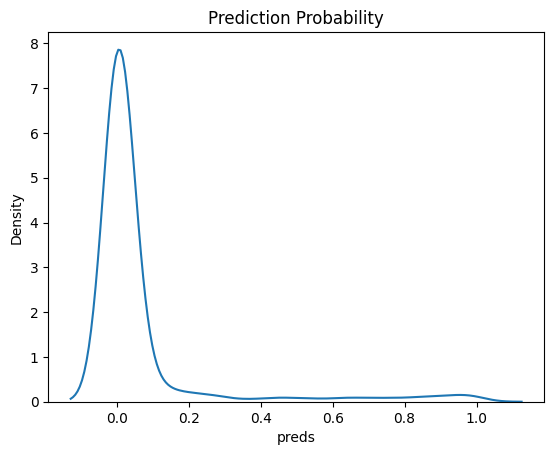

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.distplot(resultsDf.preds, hist=False, rug=False)
plt.title('Prediction Probability')
plt.show()

In [14]:
from sklearn.metrics import accuracy_score


print('Discharge mortality accuracy: ', str(accuracy_score([ 0 if pred < 0.09 else 1 for pred in resultsDf.preds], resultsDf.death_adm)))

Discharge mortality accuracy:  0.8738789237668162


In [15]:
from sklearn.metrics import balanced_accuracy_score


print('Discharge mortality balanced accuracy: ', str(balanced_accuracy_score([ 0 if pred < 0.09 else 1 for pred in resultsDf.preds], resultsDf.death_adm)))

Discharge mortality balanced accuracy:  0.7039884295933554


In [16]:
from sklearn.metrics import precision_score


print('Discharge mortality average precision: ', str(precision_score([ 0 if pred < 0.09 else 1 for pred in resultsDf.preds], resultsDf.death_adm)))

Discharge mortality average precision:  0.4700460829493088


In [17]:
from sklearn.metrics import f1_score


print('Discharge mortality F1: ', str(f1_score([ 0 if pred < 0.09 else 1 for pred in resultsDf.preds], resultsDf.death_adm)))

Discharge mortality F1:  0.4755244755244756


In [18]:
from sklearn.metrics import roc_auc_score


print('Discharge mortality AUROC: ', str(roc_auc_score([ 0 if pred < 0.09 else 1 for pred in resultsDf.preds], resultsDf.death_adm)))

Discharge mortality AUROC:  0.7039884295933554


In [19]:
import os
import sys

sys.path.append(os.environ['EICU_EHR_PIPELINE_BASE'] + "/EHR-ML")


from ehrml.utils import MlUtils

print('Discharge mortality MCC-F1: ', str(MlUtils.calculateMccF1([ 0 if pred < 0.09 else 1 for pred in resultsDf.preds], resultsDf.death_adm)))

Discharge mortality MCC-F1:  0.5734377356542281


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10), title='Confusion Matrix for the classifier'):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm_perc, annot=annot, fmt='', ax=ax, cmap='RdPu', annot_kws={"size":16})
    #plt.savefig(filename)
    plt.title(title)
    plt.show()


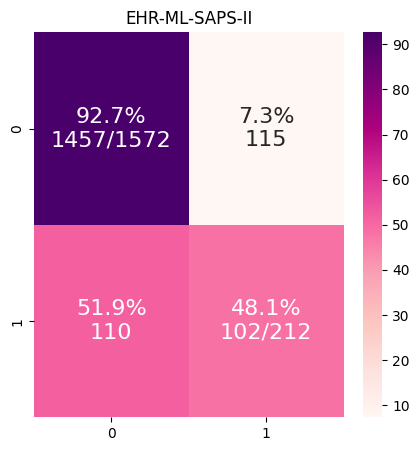

In [21]:
cm_analysis([ 0 if pred < 0.09 else 1 for pred in resultsDf.preds], resultsDf.death_adm, [0, 1], ymap=None, figsize=(5, 5), title='EHR-ML-SAPS-II')

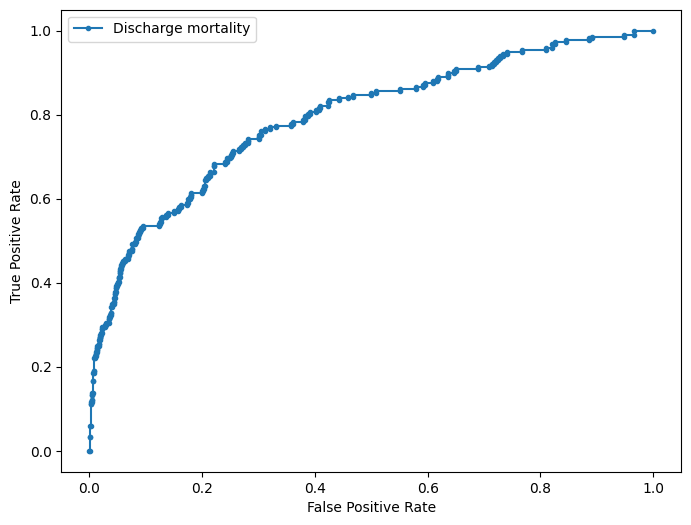

In [22]:
from sklearn.metrics import roc_curve


plt.figure(figsize=(8, 6))

fpr, tpr, _  = roc_curve(resultsDf.death_adm, resultsDf.preds)
plt.plot(fpr, tpr, marker='.', label='Discharge mortality')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()
